## Imports

In [17]:
!pip install tensorflow

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [20]:
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person629_bacteria_2509.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person952_bacteria_2877.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1315_virus_2270.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1392_bacteria_3538.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person475_bacteria_2025.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1288_bacteria_3251.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1005_virus_1688.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person442_virus_900.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person755_bacteria_2659.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person655_bacteria_2547.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray

In [21]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) / 255.0  # Normalize

                data.append((resized_arr, class_num))
            except Exception as e:
                print(f"Error processing {img}: {e}")


    return np.array(data, dtype=object)

### Loading the data set

In [22]:
train = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train/')
test = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test/')
val = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/val/')

### Data visualization & Preprocessing.

<Axes: xlabel='Condition', ylabel='count'>

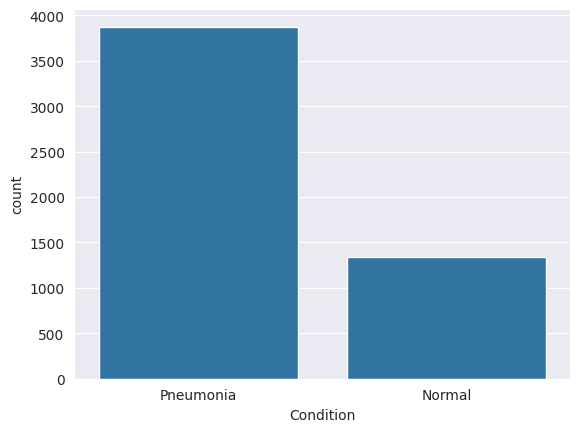

In [23]:
l = []
for i in train:
    if (i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')

#Converding the list into a dataframe so that countplot can accept it.
df = pd.DataFrame({"Condition": l})


sns.countplot(x="Condition", data=df)

### Previewing the images of both the classes.

Text(0.5, 1.0, 'NORMAL')

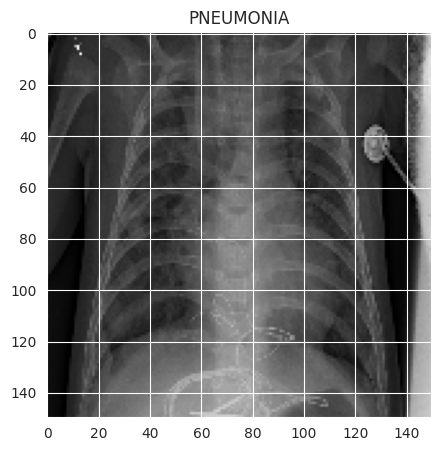

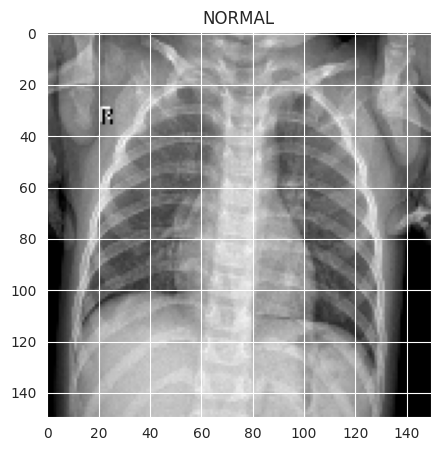

In [24]:
plt.figure(figsize= (5,5))
plt.imshow(train[0][0], cmap="gray")
plt.title(labels[train[0][1]])


plt.figure(figsize= (5,5))
plt.imshow(train[-1][0], cmap="gray")
plt.title(labels[train[-1][1]])

### We perform a grayscale normalization to reduce the effect of illumination's differences. Moreover, the CNN converges faster on [0..1] data than on [0...255]

In [25]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Make them into arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [26]:
# try to resize data to mauybe get better output.
x_train = x_train.reshape(-1, img_size, img_size, 1)


x_test = x_test.reshape(-1, img_size, img_size, 1)


x_val = x_val.reshape(-1, img_size, img_size, 1)


### Data Augmentation

In [27]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [28]:
datagen.fit(x_train)

### Training the Model

In [29]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

# DIT IS AL GERUND, DOE HET NIET OPNIEUW TENZIJ JE KOSTBARE TIJD WILT VERSPILLN

In [31]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12, validation_data= datagen.flow(x_val, y_val), callbacks =[learning_rate_reduction])

Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.7783 - loss: 1.5687 - val_accuracy: 0.5000 - val_loss: 21.0827 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.8855 - loss: 0.2701 - val_accuracy: 0.5000 - val_loss: 30.1859 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9149 - loss: 0.2216
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.9149 - loss: 0.2216 - val_accuracy: 0.5000 - val_loss: 24.0312 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.9520 - loss: 0.1680 - val_accuracy: 0.5000 - val_loss: 20.0630 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9489 - loss: 0.1360 - val_accuracy: 0.5625 - val_loss: 1.4604 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9540 - lo

In [32]:
print("Loss of the model is - " , model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9239 - loss: 0.1965
Loss of the model is -  0.276521235704422
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9239 - loss: 0.1965
Accuracy of the model is -  91.34615659713745 %


### Analysis after model training

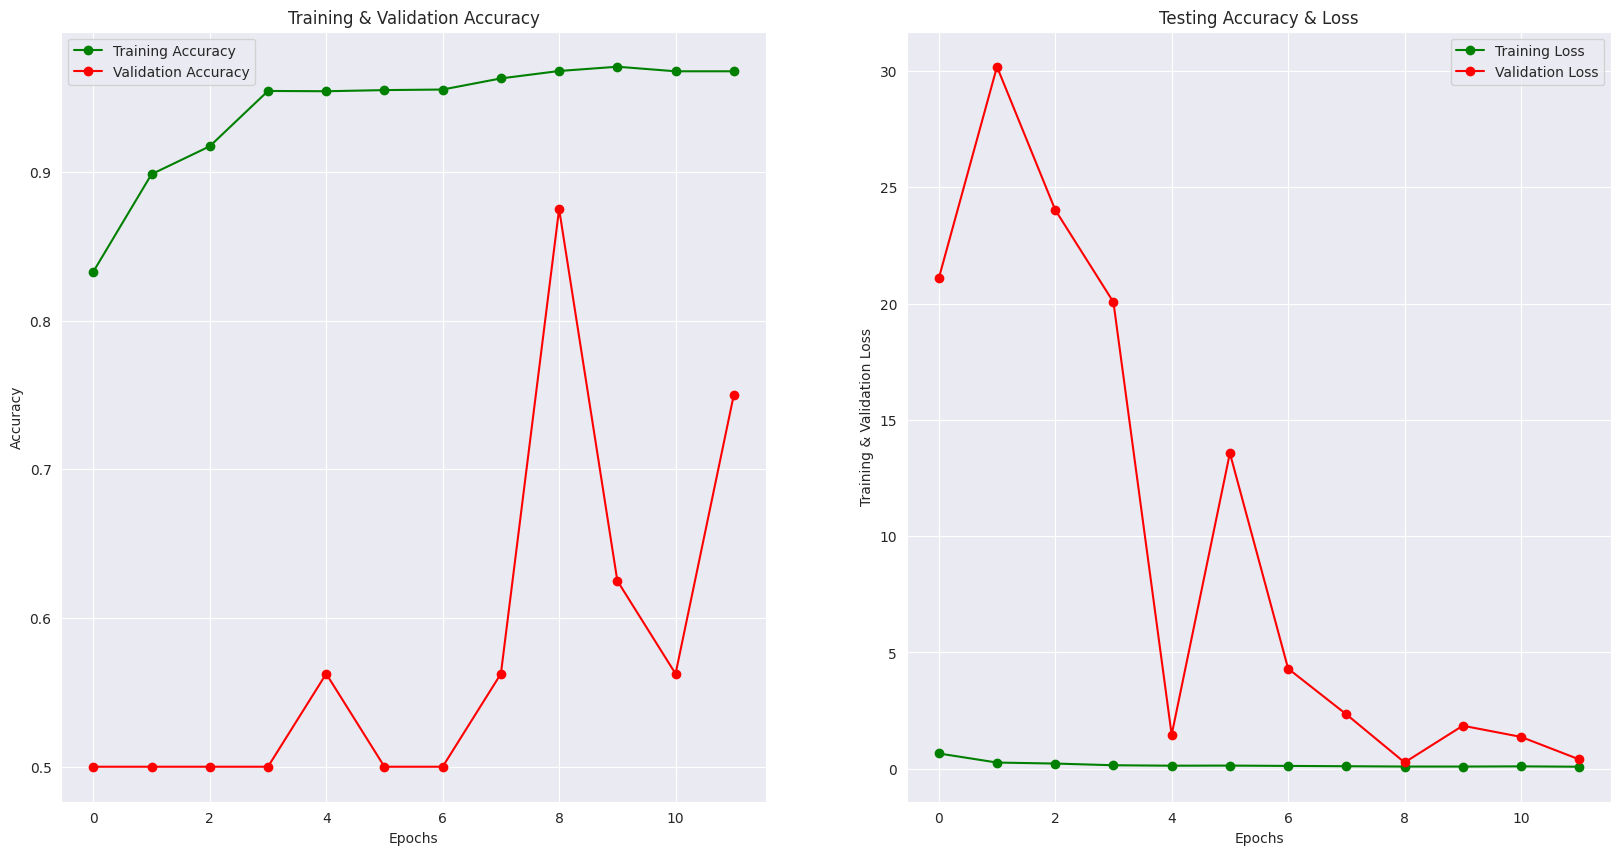

In [33]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [34]:
# predictions = model.predict_classes(x_test)
predictions = (model.predict(x_test) > 0.5).astype("int32").flatten()
predictions = predictions.reshape(1,-1)[0]
predictions[:46]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

In [35]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.94      0.93       390
   Normal (Class 1)       0.89      0.87      0.88       234

           accuracy                           0.91       624
          macro avg       0.91      0.91      0.91       624
       weighted avg       0.91      0.91      0.91       624



In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

In [37]:
cm = confusion_matrix(y_test,predictions)
cm

array([[366,  24],
       [ 30, 204]])

### Deze stuk hoeft aleen als er sns.heatmap gebruiken, maar dat zorgde dat niet alle cijfers zichtbaar waren dus heb CunfusionMatrixDisplay gebruikt.

In [38]:
# cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Figure size 1000x1000 with 0 Axes>

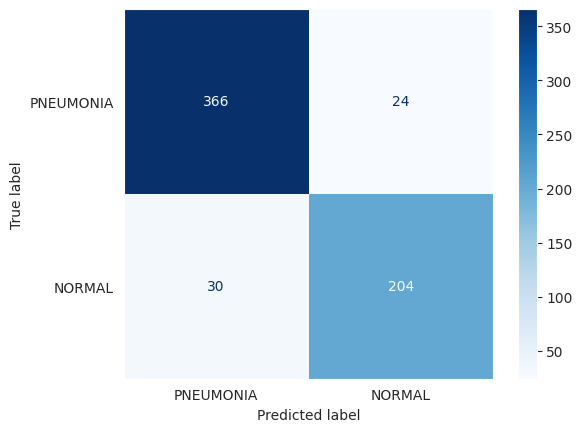

In [39]:
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', colorbar=True)
plt.grid(False)


In [40]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

### Some correctly predicted classes

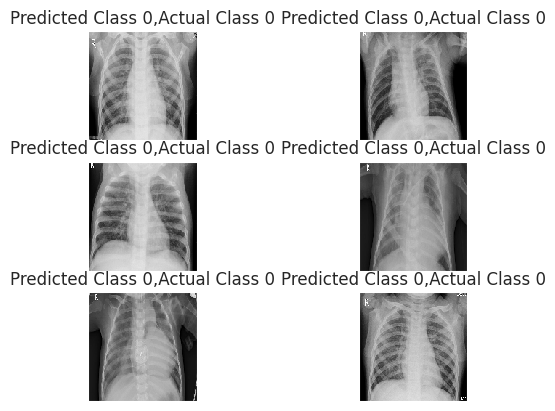

In [41]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    # plt.tight_layout()
    i += 1

### Some incorrectly predicted classes

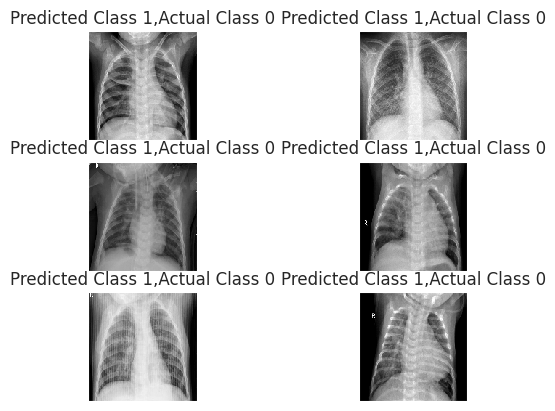

In [42]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    # plt.tight_layout()
    i += 1